# 仿真场景迟滞测试
初始状态10m/s稳态，前车10s减速至5m/s，维持100s后，再10s加速至15m/s

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.reset_defaults()
%load_ext autoreload
%autoreload 2

In [12]:
from trasim_simplified.core.constant import CFM
from trasim_simplified.util.hysteresis.intensity import cal_sv_intensity
from trasim_simplified.util.hysteresis.sim_scenario import slow_to_go_sim
from trasim_simplified.core.kinematics.cfm import get_cf_default_param, get_cf_func, get_cf_equilibrium
from trasim_simplified.core.kinematics.cfm.CFModel_IDM import cf_IDM_equilibrium_module, cf_IDM_acc_module, cf_IDM_acc, cf_IDM_equilibrium

cf_name = CFM.ACC
# param_names = ["s0", "v0", "T", "omega", "d", "delta"]
param_names = ["k1", "k2", "thw", "s0"]
cf_func = get_cf_func(cf_name)
cf_e = get_cf_equilibrium(cf_name)
# cf_func = cf_IDM_acc_module
# cf_func = cf_IDM_acc
# cf_e = cf_IDM_equilibrium_module
# cf_e = cf_IDM_equilibrium

In [3]:
import pandas as pd

param_df: pd.DataFrame = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_param_df" + f"_{cf_name}.pkl")
param_df

,k1,k2,thw,s0,Pair_ID,ObjV
0,0.124986,0.169610,1.691227,5.329428,192,10.967982
1,0.159520,0.429311,0.873451,4.480896,195,16.208090
2,0.098710,0.597873,1.327896,6.514082,196,7.139559
3,0.235443,0.011608,1.624041,5.858278,197,7.408673
4,0.082705,0.487130,1.495066,5.329590,199,9.336257
...,...,...,...,...,...,...
315,0.721049,1.000000,1.987734,0.000000,6216,12.490086
316,0.113239,0.504663,0.715666,4.560661,6394,19.288854
317,0.064562,0.395280,1.393776,5.998335,6395,20.285643
318,0.639807,0.000000,1.659908,2.246723,6417,18.746837


In [4]:
from trasim_simplified.util.calibrate.clb_cf_model import cf_param_types
cf_param = param_df[param_names].describe().loc["mean"].to_dict()
cf_param = {param_name: (round(cf_param[param_name]) if cf_param_types[cf_name][param_name] == 1 else cf_param[param_name]) for param_name in param_names}
cf_param

Using geatpy


{'k1': 0.24171344935894012,
 'k2': 0.4928579360246658,
 'thw': 1.473714530467987,
 's0': 4.5977044105529785}

In [13]:
def single_run(cf_func_, cf_param_, cf_e_):
    dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_, dec_lx_, acc_lx_ = slow_to_go_sim(cf_func_, cf_param_, cf_e=cf_e_, warmup_time=100, dec_time=10, slow_time=100, acc_time=10, hold_time=100, init_v=10, dv=5)
    vs_results = cal_sv_intensity(dec_s_, dec_v_, acc_s_, acc_v_, cf_e_, cf_param_)
    return {**cf_param_, **vs_results}, (dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_, dec_lx_, acc_lx_)

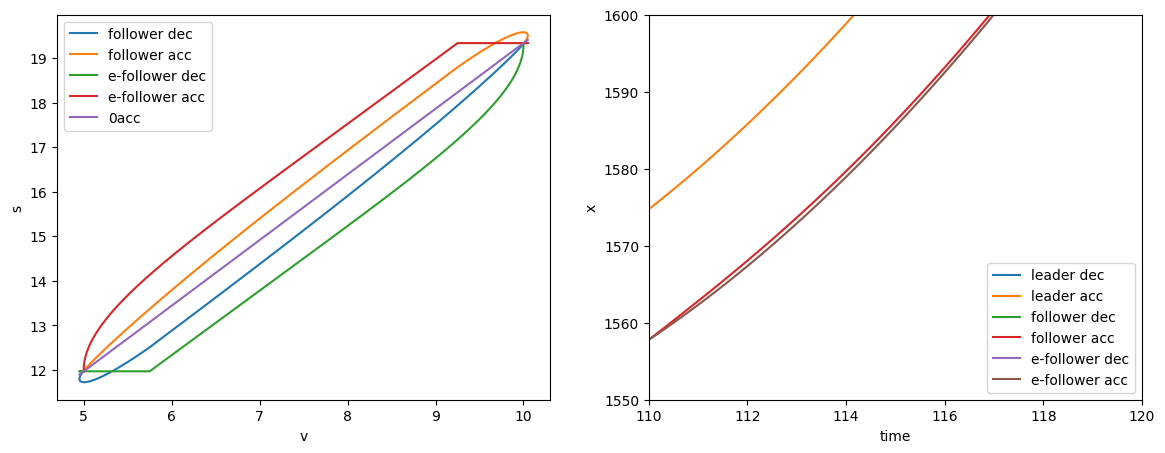

In [26]:
# 迟滞计算图
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax = ax.flatten()
ax: list[plt.Axes] = ax
fig: plt.Figure = fig

result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv, dec_lx, acc_lx) = single_run(cf_func, cf_param, cf_e)
ax[0].plot(dec_v, dec_s, label="follower dec")
ax[0].plot(acc_v, acc_s, label="follower acc")
ax[0].plot(dec_v, cf_e(**cf_param, speed=dec_lv), label="e-follower dec")
ax[0].plot(acc_v, cf_e(**cf_param, speed=acc_lv), label="e-follower acc")
min_v = min(min(dec_v), min(acc_v), min(dec_lv), min(acc_lv))
max_v = max(max(dec_v), max(acc_v), max(dec_lv), max(acc_lv))
ax[0].plot(np.linspace(min_v, max_v, 10), cf_e(**cf_param, speed=np.linspace(min_v, max_v, 10)), label="0acc")

ax[0].set_xlabel("v")
ax[0].set_ylabel("s")
ax[0].legend()

ax[1].plot(np.arange(len(dec_a)) * 0.1, dec_lx, label="leader dec")
ax[1].plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_lx, label="leader acc")
ax[1].plot(np.arange(len(dec_a)) * 0.1, dec_lx - dec_s - 5, label="follower dec")
ax[1].plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_lx - acc_s - 5, label="follower acc")

ax[1].plot(np.arange(len(dec_a)) * 0.1, dec_lx - 5 - cf_e(**cf_param, speed=dec_lv), label="e-follower dec")
ax[1].plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_lx - 5 - cf_e(**cf_param, speed=acc_lv), label="e-follower acc")
ax[1].set_xlabel("time")
ax[1].set_ylabel("x")
ax[1].set_xlim([110, 120])
ax[1].set_ylim([1550, 1600])
ax[1].legend()

# 单参数迟滞强度敏感性分析

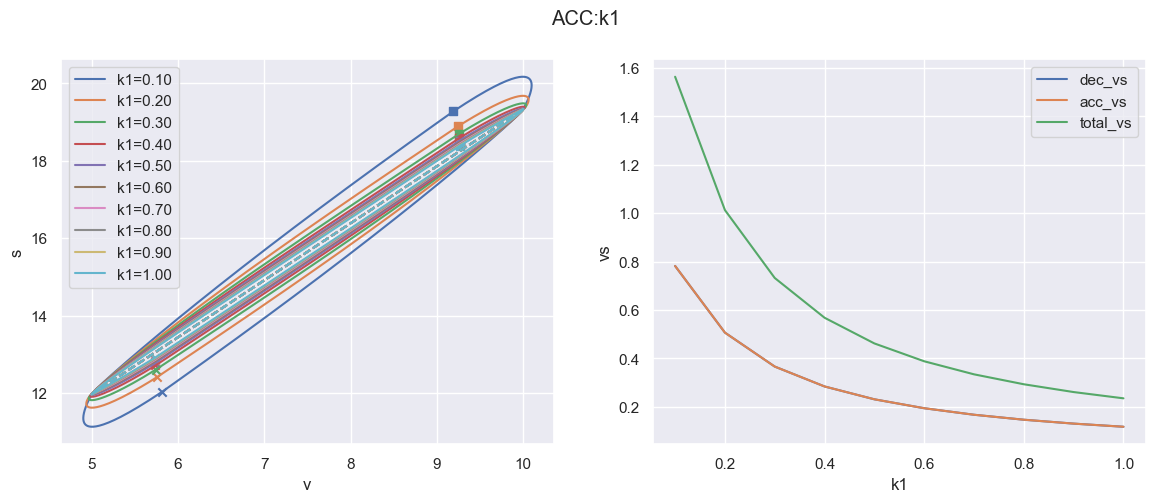

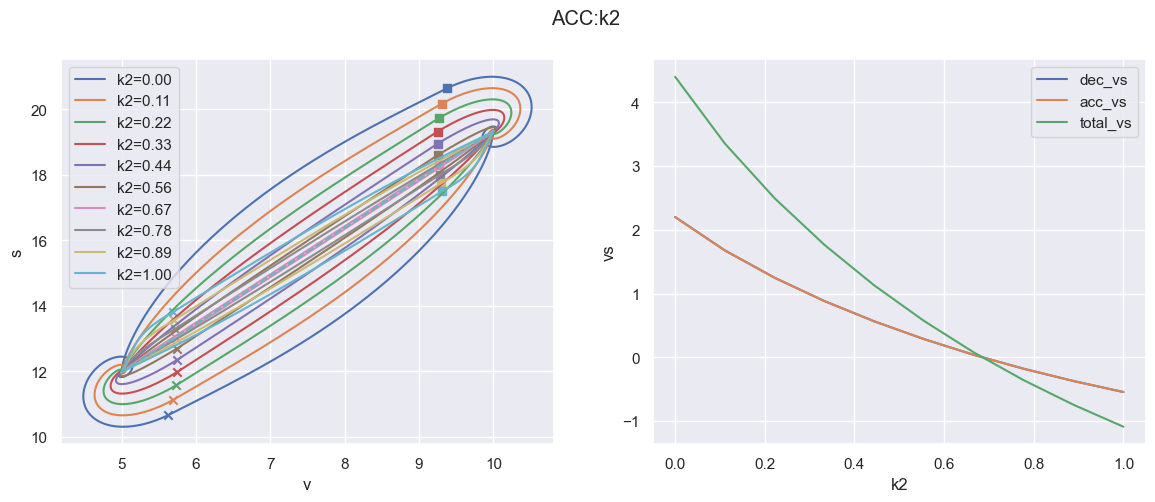

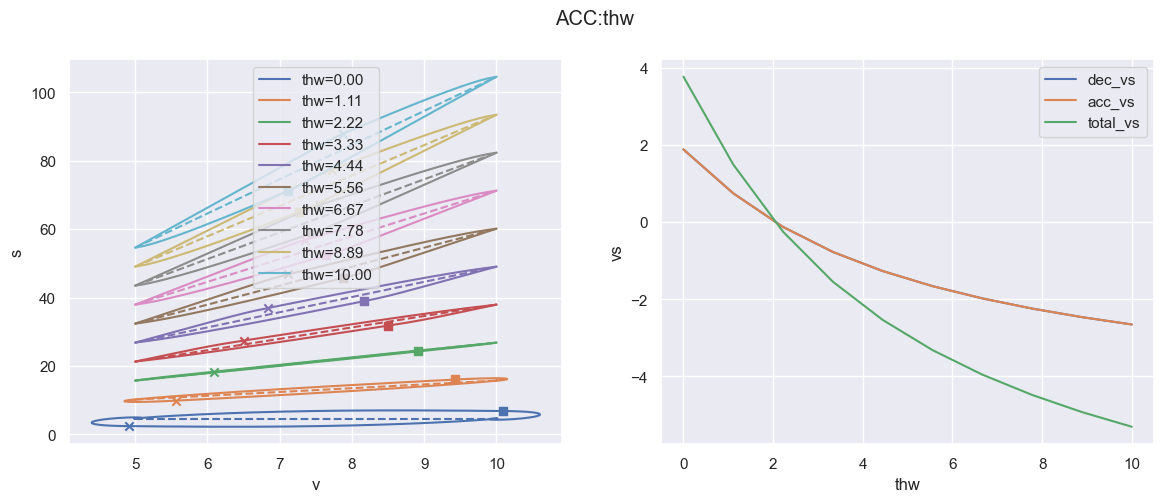

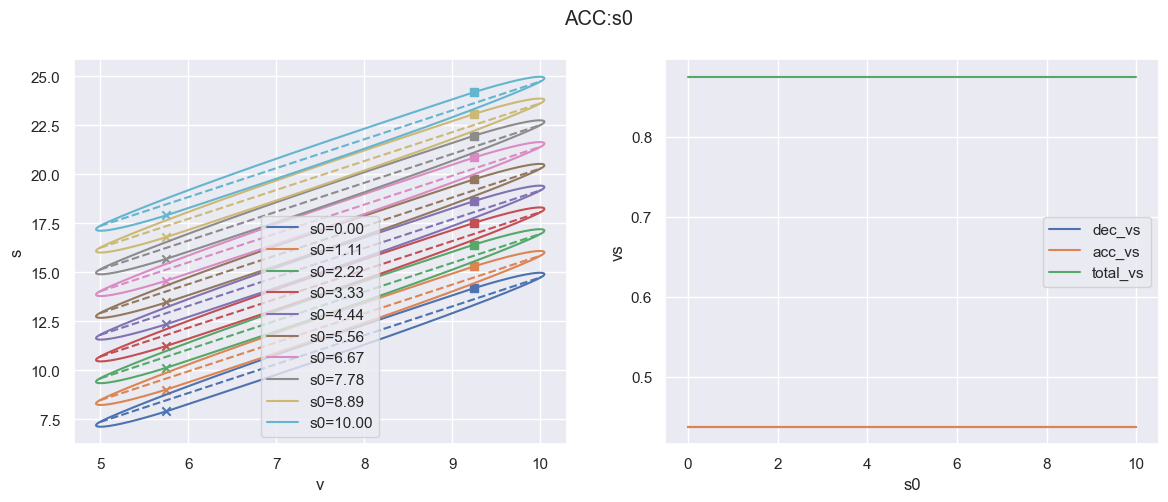

In [35]:
from trasim_simplified.util.calibrate.clb_cf_model import cf_param_ranges

sns.set_theme()

for param_name in param_names:
    param_range = cf_param_ranges[cf_name][param_name]
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax: list[plt.Axes] = ax
    fig: plt.Figure = fig
    fig.suptitle(cf_name + ":" + param_name)
    results = []
    param_values = np.linspace(param_range[0], param_range[1], 10)
    # 特殊案例处理
    if cf_name == CFM.IDM:
        if param_name == "v0":
            param_values = np.linspace(15, 50, 10)
    if cf_name == CFM.ACC:
        if param_name == "k1":
            param_values = np.linspace(0.1, 1, 10)
    
    temp_a = []
    for param_value in param_values:
        cf_param_copy = cf_param.copy()
        cf_param_copy[param_name] = param_value if cf_param_types[cf_name][param_name] == 0 else round(param_value)
        result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a) = single_run(cf_func, cf_param_copy, cf_e)
        results.append(result)
        # 进行sv轨迹的绘制
        temp: list[plt.Line2D] = ax[0].plot(dec_v, dec_s)
        ax[0].plot(acc_v, acc_s, color=temp[-1].get_color(), label=f"{param_name}={param_value:.2f}")
        ax[0].set_xlabel("v")
        ax[0].set_ylabel("s")
        ax[0].plot(np.linspace(5, 10, 10), cf_e(**cf_param_copy, speed=np.linspace(5, 10, 10)), color=temp[-1].get_color(), linestyle="--")
        # 绘制前车完成减速时的后车状态
        ax[0].scatter(dec_v[100], dec_s[100], color=temp[-1].get_color(), marker="x")
        ax[0].scatter(acc_v[100], acc_s[100], color=temp[-1].get_color(), marker="s")
    # 进行迟滞强度的绘制
    ax[1].plot(param_values, [result["dec_vs"] for result in results], label="dec_vs")
    ax[1].plot(param_values, [result["acc_vs"] for result in results], label="acc_vs")
    ax[1].plot(param_values, [result["total_vs"] for result in results], label="total_vs")
    ax[1].set_xlabel(param_name)
    ax[1].set_ylabel("vs")
    ax[1].legend()
    ax[0].legend()
    fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\param_value_change_{}_{}.png".format(cf_name, param_name))

In [1]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

for param_name in param_names:
    param_range = cf_param_ranges[cf_name][param_name]
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax: plt.Axes = ax
    fig: plt.Figure = fig
    fig.suptitle(cf_name + ":" + param_name)
    results = []
    param_values = np.linspace(param_range[0], param_range[1], 10)
    # 特殊案例处理
    if cf_name == CFM.IDM:
        if param_name == "v0":
            param_values = np.linspace(15, 50, 10)
    if cf_name == CFM.ACC:
        if param_name == "k1":
            param_values = np.linspace(0.1, 1, 10)

    temp_a = []
    axins = ax.inset_axes((0.65, 0.6, 0.3, 0.3))
    axins2 = ax.inset_axes((0.2, 0.1, 0.3, 0.3))
    for param_value in param_values:
        cf_param_copy = cf_param.copy()
        cf_param_copy[param_name] = param_value if cf_param_types[cf_name][param_name] == 0 else round(param_value)
        result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a) = single_run(cf_func, cf_param_copy, cf_e)
        # 进行sv轨迹的绘制
        temp: list[plt.Line2D] = ax.plot(np.arange(len(dec_a)) * 0.1, dec_a)
        ax.plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_a, color=temp[-1].get_color(), label=f"{param_name}={param_value:.2f}", linestyle="--")

        # 在子坐标系中绘制原始数据
        axins.plot(np.arange(len(dec_a)) * 0.1, dec_a, color=temp[-1].get_color())
        axins.plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_a, color=temp[-1].get_color(), linestyle="--")
        axins.vlines(120, -1, 1, color="k", linestyle="--", linewidth=0.1)
        
        axins2.plot(np.arange(len(dec_a)) * 0.1, dec_a, color=temp[-1].get_color())
        axins2.plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_a, color=temp[-1].get_color(), linestyle="--")
        axins2.vlines(10, -1, 1, color="k", linestyle="--", linewidth=0.1)
        
        ax.set_xlabel("time")
        ax.set_ylabel("acc")
    ax.legend()

    # 调整子坐标系的显示范围
    axins.set_xlim(110, 130)
    axins.set_ylim(0.4, 0.6)
    axins2.set_xlim(0, 20)
    axins2.set_ylim(-0.6, -0.4)

    # 建立父坐标系与子坐标系的连接线
    # loc1 loc2: 坐标系的四个角
    # 1 (右上) 2 (左上) 3(左下) 4(右下)
    mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec='k', lw=1)
    mark_inset(ax, axins2, loc1=4, loc2=2, fc="none", ec='k', lw=1)
    fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\param_value_change_acc_profile_{}_{}.png".format(cf_name, param_name))

NameError: name 'param_names' is not defined

In [12]:
import joblib
from itertools import product

pos = np.arange(0.1, 2, 0.1)
print(pos)
k_list = list(product(pos, pos, pos))

# results = joblib.Parallel(n_jobs=-1)(joblib.delayed(single_run)(cf_func, {**cf_param, "k_speed": k[0], "k_space": k[1], "k_zero": k[2]}, cf_e) for k in k_list for cf_param in cf_params)  # 参数稳定性不足容易报错
results = joblib.Parallel(n_jobs=-1)(joblib.delayed(single_run)(cf_func, {**cf_param, "k_speed": k[0], "k_space": k[1], "k_zero": k[2]}, cf_e) for k in k_list)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9]


In [13]:
result_df = pd.DataFrame([list(result[0].values()) for result in results], columns=results[0][0].keys())
result_df

,v0,s0,s1,delta,T,omega,d,k_speed,k_space,k_zero,...,total_ts,dec_avg_acc,acc_avg_acc,dec_avg_speed,acc_avg_speed,min_speed,max_speed,dv,dec_step,acc_step
0,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.1,...,175.375563,0.088637,0.085411,5.111473,9.031199,3.613475,13.000127,9.386652,1059,1099
1,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.2,...,168.706402,0.088693,0.085546,5.144515,9.241362,3.804705,13.206160,9.401455,1060,1099
2,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.3,...,174.909719,0.085303,0.082276,5.161428,9.014042,3.939974,12.982098,9.042124,1060,1099
3,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.4,...,181.004107,0.082660,0.079651,5.156474,8.813159,4.031330,12.785012,8.753682,1059,1099
4,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.5,...,182.522887,0.081682,0.078709,5.155301,8.771191,4.094060,12.744189,8.650129,1059,1099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,33.3,2,0,4,1.6,0.73,1.67,1.9,1.9,1.5,...,1.620812,0.090981,0.090981,5.657983,14.333086,5.000000,14.998850,9.998850,1099,1099
6855,33.3,2,0,4,1.6,0.73,1.67,1.9,1.9,1.6,...,1.483577,0.090977,0.090977,5.657983,14.333176,5.000000,14.998335,9.998334,1099,1099
6856,33.3,2,0,4,1.6,0.73,1.67,1.9,1.9,1.7,...,1.347074,0.090971,0.090971,5.657983,14.333295,5.000001,14.997703,9.997702,1099,1099
6857,33.3,2,0,4,1.6,0.73,1.67,1.9,1.9,1.8,...,1.211326,0.090964,0.090964,5.657983,14.333446,5.000002,14.996953,9.996952,1099,1099


In [23]:
result_df = result_df[(np.isfinite(result_df["dec_vs"]) & np.isfinite(result_df["acc_vs"]))]
for k in ["k_speed", "k_space", "k_zero"]:
    other = [i for i in ["k_speed", "k_space", "k_zero"] if i != k]
    temp = result_df[(result_df[other[0]] == 1.) & (result_df[other[1]] == 1.)]
    
    # temp: pd.DataFrame = temp.groupby([k]).mean().reset_index()
    print(temp)
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    axes: np.ndarray[plt.Axes] = axes
    # ax.plot(temp[k], temp["dec_vs"], label="dec_vs")
    # ax.plot(temp[k], temp["acc_vs"], label="acc_vs")
    # ax.plot(temp[k], temp["total_vs"], label="total_vs")

    for ax_, index in zip(axes, ["dec_vs", "acc_vs", "total_vs"]):
        ax_: plt.Axes = ax_
        # ax_.boxplot([result_df[result_df[k] == i][index] for i in temp[k]], positions=temp[k], showfliers=False, widths=0.1)
        ax_.plot(temp[k], temp[index], label=index)
        # ax_.set_xscale("log")
        # ax_.set_xticks(temp[k])
        # ax_.set_xticklabels([f"{t:.1f}" for t in temp[k]])
        # ax_.set_xlim([-0.5, 5.5])
        ax_.grid()
        ax_.set_title(k + "_" + index)
    fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_{}_virtual_scenario.png".format(k))
result_df.to_csv(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_infinite_virtual_scenario.csv", index=False)

        v0  s0  s1  delta    T  omega     d  k_speed  k_space  k_zero  ...  \
180   33.3   2   0      4  1.6   0.73  1.67      0.1      1.0     1.0  ...   
541   33.3   2   0      4  1.6   0.73  1.67      0.2      1.0     1.0  ...   
902   33.3   2   0      4  1.6   0.73  1.67      0.3      1.0     1.0  ...   
1263  33.3   2   0      4  1.6   0.73  1.67      0.4      1.0     1.0  ...   
1624  33.3   2   0      4  1.6   0.73  1.67      0.5      1.0     1.0  ...   
1985  33.3   2   0      4  1.6   0.73  1.67      0.6      1.0     1.0  ...   
2346  33.3   2   0      4  1.6   0.73  1.67      0.7      1.0     1.0  ...   
2707  33.3   2   0      4  1.6   0.73  1.67      0.8      1.0     1.0  ...   
3068  33.3   2   0      4  1.6   0.73  1.67      0.9      1.0     1.0  ...   
3429  33.3   2   0      4  1.6   0.73  1.67      1.0      1.0     1.0  ...   
3790  33.3   2   0      4  1.6   0.73  1.67      1.1      1.0     1.0  ...   
4151  33.3   2   0      4  1.6   0.73  1.67      1.2      1.0   

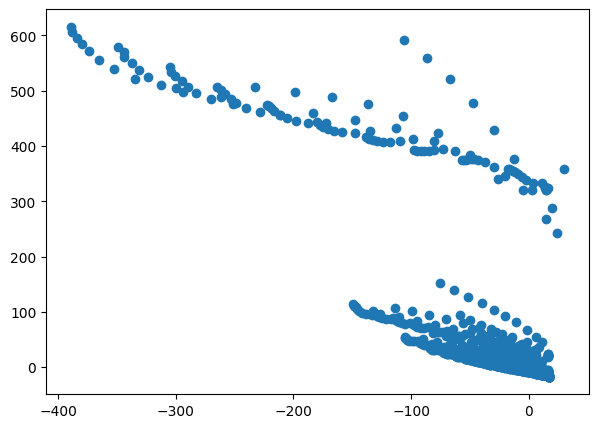

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(result_df["dec_vs"], result_df["acc_vs"])

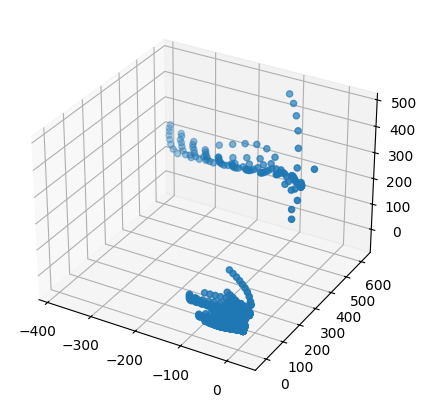

In [75]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
ax: Axes3D = ax
ax.scatter(result_df["dec_vs"], result_df["acc_vs"], result_df["total_vs"])